# Constrained Exploitation

This section implements constrained exploitation process where the next infill point is obtained by minimizing surrogate prediction while taking into account the constraints. The optimization problem statement is written as

$$
\begin{align*}
    \min_{x} \quad & \hat{f}(x) \\ 
    \text{s.t.} \quad & \hat{g}_j(x) \leq 0 \quad i = 1, \dots, J
\end{align*}
$$

where $\hat{f}(x)$ is the surrogate model prediction, $\hat{g}(x)$ is the constraint model, and $J$ is the number of constraints. Below code imports required packages, defines modified branin function, constraint, and creates plotting data:

In [76]:
# Imports
import numpy as np
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    t = 1 / (8*np.pi)

    y = (x2 - b*x1**2 + c*x1 - 6)**2 + 10*(1-t)*np.cos(x1) + 10 + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

def constraint(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    g = -x1*x2 + 30
    
    if dim == 1:
        g = g.reshape(-1)

    return g

# Bounds
lb = np.array([-5, 0])
ub = np.array([10, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ))
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)
gplot = constraint(xplot)

Differential evolution (DE) from `pymoo` is used for minimizing the surrogate model. Below code defines problem class and initializes DE. Note how problem class uses both the objective and constraint surrogate models.

In [77]:
# Problem class
class Surrogate(Problem):

    def __init__(self, sm_func, sm_const):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1, xl=lb, xu=ub)

        self.sm_func = sm_func # store function surrogate model
        self.sm_const = sm_const # store constraint surrogate model

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = self.sm_func.predict_values(x)
        out["G"] = self.sm_const.predict_values(x)

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

Below block of code creates 5 training points and performs sequential sampling using constrained exploitation. The maximum number of iterations is set to 15 and a convergence criterion is defined based on the change in true function value for infill points between two consecutive iterations.

In [78]:
sampler = LHS(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 5
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)
gtrain = constraint(xtrain)

# Variables
itr = 0
max_itr = 15
tol = 1e-3
delta_f = [1]
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < delta_f[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_const = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm_func.set_training_values(xtrain, ytrain)
    sm_const.set_training_values(xtrain, gtrain)
    
    # Creating surrogate model
    sm_func.train()
    sm_const.train()

    # Find the minimum of surrogate model
    result = minimize(Surrogate(sm_func, sm_const), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    if itr == 0:
        delta_f = [np.abs(result.F - y_infill)/np.abs(result.F)]
    else:
        delta_f = np.append(delta_f, np.abs(result.F - y_infill)/np.abs(result.F))
    
    print("Change in f: {}".format(delta_f[-1]))
    print("f*: {}".format(y_infill))
    print("x*: {}".format(result.X))
    print("g*: {}".format(constraint(result.X)))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    gtrain = np.append( gtrain, constraint(result.X) )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results

ybest = np.min(ytrain[gtrain < 0])
index = np.where(ytrain == ybest)[0][0]

print("\nBest feasible point:")
print("x*: {}".format(xtrain[index,:]))
print("f*: {}".format(ybest))
print("g*: {}".format(gtrain[index]))


Iteration 1
Change in f: [4.87820514]
f*: [100.46965948]
x*: [ 1.86308358 12.64406216]
g*: [6.44305539]

Iteration 2
Change in f: 0.11385743631174057
f*: [43.43418663]
x*: [4.92716358 3.89282162]
g*: [10.81943108]

Iteration 3
Change in f: 0.033346138579188826
f*: [55.67501068]
x*: [7.77223795 3.88939754]
g*: [-0.22932317]

Iteration 4
Change in f: 0.06868713449154168
f*: [51.41012523]
x*: [8.25673269 3.63829195]
g*: [-0.04040406]

Iteration 5
Change in f: 0.584630207528755
f*: [51.94314091]
x*: [10.          3.00345085]
g*: [-0.03450853]

Iteration 6
Change in f: 0.002630879397340474
f*: [47.56090249]
x*: [9.13086319 3.28558194]
g*: [-0.0001992]

Iteration 7
Change in f: 1.2718804684214657e-07
f*: [47.55995926]
x*: [9.14357367 3.28099524]
g*: [-2.17287872e-05]

Best feasible point:
x*: [9.14357367 3.28099524]
f*: 47.55995925892863
g*: -2.1728787171326758e-05


Below block of code plots the convergence of constrained exploitation process.

Text(0.5, 0.98, 'Constrained Exploitation')

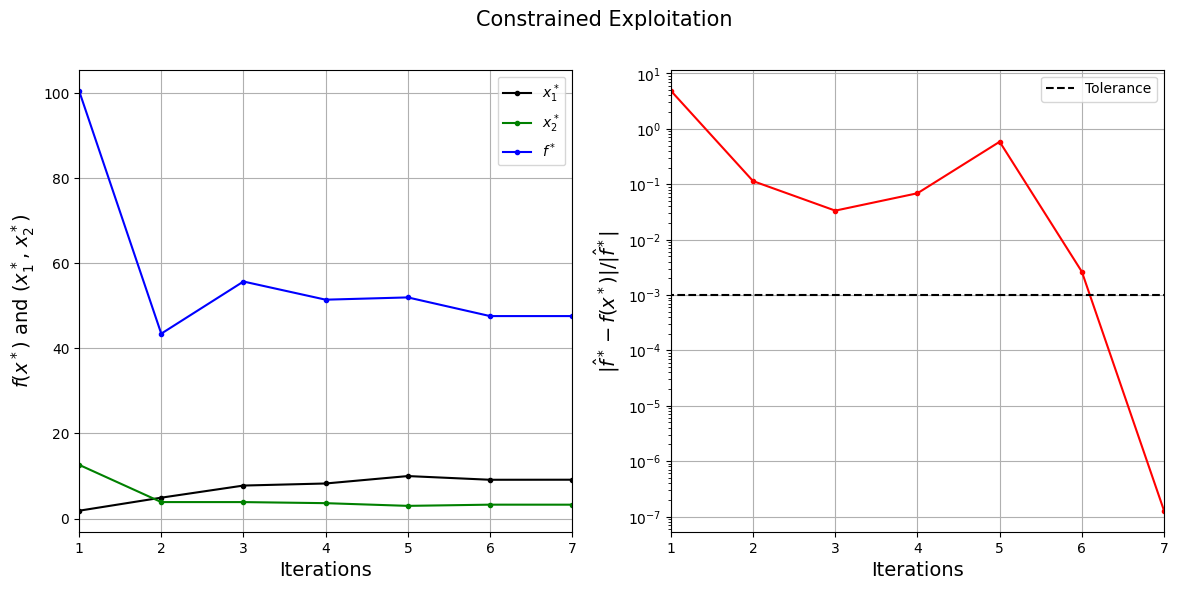

In [81]:
####################################### Plotting convergence history

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(np.arange(itr) + 1, xtrain[num_train:,0], c="black", label='$x_1^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, xtrain[num_train:,1], c="green", label='$x_2^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, ytrain[num_train:], c="blue", label='$f^*$', marker=".")
ax[0].set_xlabel("Iterations", fontsize=14)
ax[0].set_ylabel("$f(x^*)$ and ($x_1^*$, $x_2^*$)", fontsize=14)
ax[0].legend()
ax[0].set_xlim(left=1, right=itr)
ax[0].grid()

ax[1].plot(np.arange(itr) + 1, delta_f, c="red", marker=".")
ax[1].plot(np.arange(itr+1), [tol]*(itr+1), c="black", linestyle="--", label="Tolerance")
ax[1].set_xlabel("Iterations", fontsize=14)
ax[1].set_ylabel(r"$| \hat{f}^* - f(x^*) | / | \hat{f}^* |$", fontsize=14)
ax[1].set_xlim(left=1, right=itr)
ax[1].grid()
ax[1].legend()
ax[1].set_yscale("log")

fig.suptitle("Constrained Exploitation".format(itr), fontsize=15)

The figure on the left shows the history of infill points and corresponding true function values, and figure on the right shows the convergence of constrained exploitation process. At the start, infill points are added at different locations since the surrogate model is changing which results in different minima. As the number of iterations increases, new infill points are added very close to the previous infill points since the surrogate minimum is more or less same. Notice that process stopped before reaching maximum number of infills since the convergence criteria was met.

Below block of code plots the infill points.

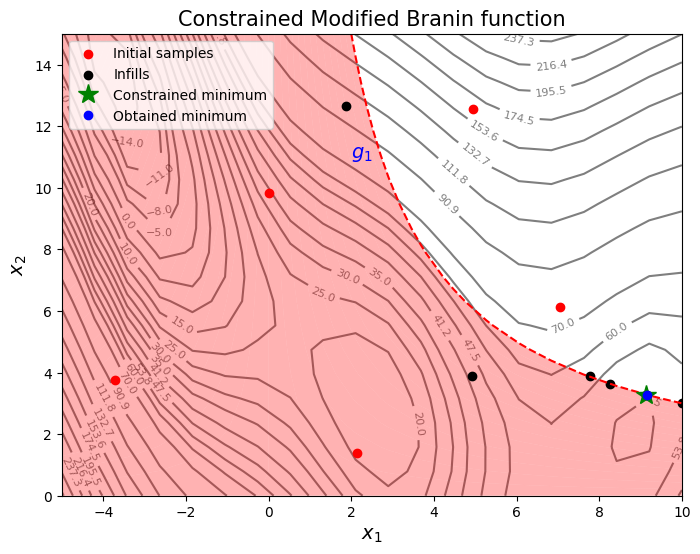

In [80]:
####################################### Plotting initial samples and infills

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)
G = gplot.reshape(reshape_size, reshape_size)

# Level
levels = np.linspace(-17, -5, 5)
levels = np.concatenate((levels, np.linspace(0, 30, 7)))
levels = np.concatenate((levels, np.linspace(35, 60, 5)))
levels = np.concatenate((levels, np.linspace(70, 300, 12)))

fig, ax = plt.subplots(figsize=(8,6))

# Plot function
CS=ax.contour(X, Y, Z, levels=levels, colors='k', linestyles='solid', alpha=0.5, zorder=-10)
ax.clabel(CS, inline=1, fontsize=8)

# Plot constraint
ax.contour(X, Y, G, levels=[0], colors='r', linestyles='dashed')
ax.contourf(X, Y, G, levels=np.linspace(0,G.max()), colors="red", alpha=0.3, antialiased = True)
ax.annotate('$g_1$', xy =(2.0, 11.0), fontsize=14, color='b')

# Plot minimum
ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
ax.plot(9.143, 3.281, 'g*', markersize=15, label="Constrained minimum")
ax.plot(xtrain[index,0], xtrain[index,1], 'bo', label="Obtained minimum")

# Asthetics
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Constrained Modified Branin function", fontsize=15)
ax.legend()

As can be seen in above plot, most of the points are concentrated in the feasible region along the constraint boundary. This is because the surrogate model is minimized while taking into account the constraints. Due to exploitation, there is a chance that infill points are stuck in a local minimum. So, it is important to balance exploration and exploitatiom.

> __*NOTE*__: Due to randomness in differential evolution, results may vary slightly between runs. So, it is recommend to run the code multiple times to see average behavior.

Final result:

| Parameter         | True minimum | Obtained minimum|
|-------------------|--------------|-----------------|
| $x_1^*$           | 9.143        | 9.144           |
| $x_2^*$           | 3.281        | 3.281           |
| $f(x_1^*, x_2^*)$ | 47.560       | 47.560          |